## Multivariate Anomaly Detection of sequential data using an LSTM Autoencoder
### Architecture defined in [Malhotra2016](https://arxiv.org/pdf/1607.00148.pdf) and Pytorch implementation found in [this blog post](https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)

## Generate Synthetic Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def syntheticdata_cosine(timesteps=100, loc=0, scale=.1, hz=3, seed=None):
    np.random.seed(seed)
    t = np.linspace(0, hz, timesteps)
    sine_wave = np.sin(2*np.pi*t)
    
    noise = np.random.normal(loc=loc, scale=scale, size=timesteps)
    sine_wave = sine_wave + noise
    
    return sine_wave


def syntheticdata_trend(timesteps=100, gradient=0.2, intercept=0, loc=0, scale=.1, seed=None):
    np.random.seed(seed)
    t = np.linspace(0, 3, timesteps)
    trend = t*gradient+intercept
    
    noise = np.random.normal(loc=loc, scale=scale, size=timesteps)
    trend = trend + noise
    
    return trend


def generate_cycle_cosine(cycle_id, starting_seed=0):
    cycle_data = []
    for i in range(starting_seed, starting_seed+10):
        cycle_data.append(syntheticdata_cosine(seed=i))
    cycle_data_df = pd.DataFrame(cycle_data).T
    cycle_data_df['cycle_id'] = cycle_id
    return cycle_data_df


def generate_cycle_trend(cycle_id, starting_seed=0):
    cycle_data = []
    for i in range(starting_seed, starting_seed+10):
        cycle_data.append(syntheticdata_trend(seed=i))
    cycle_data_df = pd.DataFrame(cycle_data).T
    cycle_data_df['cycle_id'] = cycle_id
    return cycle_data_df

In [3]:
df  = pd.DataFrame(columns =  ['cycle_id'] + [i for i in range(10)])

for cycle_id in range(20):
    if cycle_id<10:
        cycle_data_df = generate_cycle_cosine(cycle_id=str(cycle_id), starting_seed=cycle_id*10)
    else:
        cycle_data_df = generate_cycle_trend(cycle_id=str(cycle_id), starting_seed=cycle_id*10)

    df = pd.concat([df, cycle_data_df], axis=0)

df

,cycle_id,0,1,2,3,4,5,6,7,8,9
0,0,0.176405,0.162435,-0.041676,0.178863,0.005056,0.044123,-0.031178,0.169053,0.009120,0.000111
1,0,0.229267,0.128076,0.183625,0.232902,0.239246,0.156164,0.262152,0.142658,0.298380,0.160297
2,0,0.469536,0.318845,0.158043,0.381312,0.272072,0.614740,0.393445,0.374944,0.176965,0.260056
3,0,0.764730,0.433344,0.704668,0.354292,0.610001,0.515432,0.450732,0.581392,0.402006,0.539353
4,0,0.876835,0.776620,0.510735,0.662340,0.648249,0.701040,0.441401,0.611187,0.460430,0.652243
...,...,...,...,...,...,...,...,...,...,...,...
95,19,0.733303,0.579214,0.503484,0.663361,0.516225,0.563979,0.642334,0.532761,0.496564,0.642150
96,19,0.678871,0.617387,0.426308,0.661491,0.627797,0.499832,0.685299,0.625336,0.613265,0.744649
97,19,0.538156,0.541936,0.745293,0.664607,0.686112,0.518992,0.564328,0.580992,0.612326,0.598748
98,19,0.630399,0.450032,0.647960,0.547834,0.651608,0.619890,0.499811,0.417993,0.547216,0.667329


<AxesSubplot:>

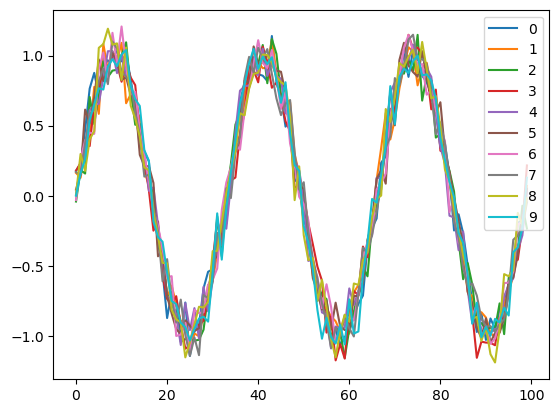

In [4]:
df[df['cycle_id']=='0'].plot()

<AxesSubplot:>

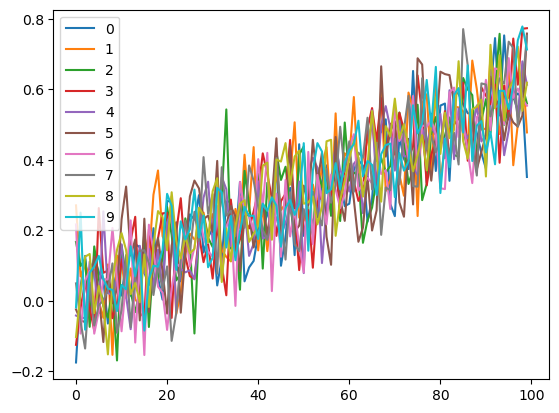

In [5]:
df[df['cycle_id']=='10'].plot()

## Prepare Pytorch Tensors

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def create_dataloader(df, batch_size: int=1, shuffle: bool=False, drop_last=False):
    
    for i, (cycle, cycle_grp) in enumerate(df.groupby('cycle_id')):
        cycle_tmp = cycle_grp.drop(columns=['cycle_id'])
        cycle_tmp = np.expand_dims(cycle_tmp, axis=0)
        if i == 0: dataset = cycle_tmp
        else: dataset = np.vstack((dataset, cycle_tmp))
    n_seq, seq_len, n_features = dataset.shape
    dataset = torch.FloatTensor(dataset)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    return dataloader, seq_len, n_features

def create_dataset(df):
    df = df.drop(columns=['cycle_id'])
    df = np.expand_dims(df, axis=0)
    dataset = torch.FloatTensor(df)
    return dataset


In [7]:
df_train = df[df['cycle_id'].isin(['0', '1', '2', '3', '4', '5', '6'])]
df_val = df[df['cycle_id'].isin(['7', '8', '9'])]


train_dataloader, seq_len, n_features = create_dataloader(df_train, batch_size=2, shuffle=True, drop_last=True)
val_dataloader, _, _ = create_dataloader(df_val)

In [8]:
train_i = next(iter(train_dataloader))
train_i.shape

torch.Size([2, 100, 10])

## Define Model Architecture

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, out_dim, h_dims, h_activ, out_activ):
        super(Encoder, self).__init__()

        layer_dims = [input_dim] + h_dims + [out_dim]
        self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        self.out_dim = out_dim
        
        for index in range(self.num_layers):
            layer = nn.LSTM(
                input_size=layer_dims[index],
                hidden_size=layer_dims[index + 1],
                num_layers=1,
                batch_first=True
            )
            self.layers.append(layer)

        self.h_activ, self.out_activ = h_activ, out_activ

    def forward(self, x):

        for index, layer in enumerate(self.layers):
            x, (h_n, c_n) = layer(x)

            if self.h_activ and index < self.num_layers - 1:
                x = self.h_activ(x)
            elif self.out_activ and index == self.num_layers - 1:
                return self.out_activ(h_n).reshape(-1, self.out_dim)

        return h_n.reshape(-1, self.out_dim)


class Decoder(nn.Module):
    def __init__(self, input_dim, out_dim, h_dims, h_activ):
        super(Decoder, self).__init__()

        layer_dims = [input_dim] + h_dims + [out_dim]
        self.num_layers = len(layer_dims) - 1
        self.layers = nn.ModuleList()
        
        for index in range(self.num_layers):
            layer = nn.LSTM(
                input_size=layer_dims[index],
                hidden_size=layer_dims[index + 1],
                num_layers=1,
                batch_first=True
            )
            self.layers.append(layer)

        self.h_activ = h_activ
        self.dense_matrix = nn.Parameter(
            torch.rand((out_dim, out_dim), dtype=torch.float),
            requires_grad=True
        )

    def forward(self, x, seq_len):
        x = x.unsqueeze(1).repeat(1, seq_len, 1) # now make [batch_size, num_features] -> [batch_size, seq_len, num_features]
        for index, layer in enumerate(self.layers):
            x, (h_n, c_n) = layer(x)

            if self.h_activ and index < self.num_layers - 1:
                x = self.h_activ(x)

        return torch.matmul(x, self.dense_matrix)


######
# MAIN
######

class LSTM_AE(nn.Module):
    def __init__(self, input_dim, encoding_dim, h_dims=[], h_activ=nn.Sigmoid(),
                 out_activ=nn.Tanh()):
        super(LSTM_AE, self).__init__()

        self.encoder = Encoder(input_dim, encoding_dim, h_dims, h_activ, out_activ)
        self.decoder = Decoder(encoding_dim, input_dim, h_dims[::-1], h_activ)

    def forward(self, x):
        seq_len = x.shape[1] # [batch, seq_len, features]
        x = self.encoder(x)
        x = self.decoder(x, seq_len)

        return x

## Define Training

In [10]:
from torch.nn import MSELoss


def train_model(
    model,
    device,
    train_dataloader,
    val_dataloader,
    lr, 
#     lr_decay,
#     lr_gamma,
    epochs, 
    denoise=False,
    verbose=True,
):
    # TODO: move device to notebook
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # initialise optimiser
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
#     if lr_decay: lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser=optimiser, gamma=lr_gamma, last_epoch=-1)

    # initialise loss
    criterion = MSELoss(reduction='mean')

    history = dict(train=[], val=[])

    for epoch in range(1, epochs + 1):
        
        model.train()

        train_losses = []

        for i, x in enumerate(train_dataloader):

            optimiser.zero_grad()

            # Forward pass
            x_prime = model(x)

            loss = criterion(x_prime, x)

            # Backward pass
            loss.backward()
            optimiser.step()

            train_losses.append(loss.item())
        
        train_loss = np.mean(train_losses)

            
            
        val_losses = []
        model = model.eval()

        # estimate validation loss
        with torch.no_grad():
            for i, seq_true in enumerate(val_dataloader):
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
                
        val_loss = np.mean(val_losses)

        # now store the losses for this epoch
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        

        # output the losses if verbose
        if verbose:
            print(f"Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {val_loss}")
    
    # output the final losses per cycle for the val dataset
    history['val_cycle_loss'] = val_losses
    
    return history


def get_encodings(model, dataset):
    model.eval()
    encodings = [model.encoder(x) for x in train_set]
    return encodings


######
# MAIN
######


def train(
    model, 
    device,
    train_dataloader,
    val_dataloader,
#     encoding_dim,  
    lr=1e-3,
    epochs=50, 
    denoise=False, 
    verbose=False,
    **kwargs
):
#     model = instantiate_model(model, train_set, encoding_dim, **kwargs)
    losses = train_model(model, device, train_dataloader, val_dataloader, lr, epochs, denoise, verbose)
#     encodings = get_encodings(model, train_set)

    return model, losses

In [11]:
# parameter options
learning_rate = 1e-3
input_features = n_features
encoding_size = 8
h_dims_sizes = [16] # list of decreasing integers, with each entry being a layer width

In [12]:
model = LSTM_AE(input_dim=10, encoding_dim=8, h_dims=[16])
model

LSTM_AE(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): LSTM(10, 16, batch_first=True)
      (1): LSTM(16, 8, batch_first=True)
    )
    (h_activ): Sigmoid()
    (out_activ): Tanh()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): LSTM(8, 16, batch_first=True)
      (1): LSTM(16, 10, batch_first=True)
    )
    (h_activ): Sigmoid()
  )
)

In [13]:
model, history = train(
    model, 
    device,
    train_dataloader,
    val_dataloader,
    lr=1e-3,
    epochs=100,
    verbose=True,
)

Epoch: 1, Training Loss: 0.5361113349596659, Validation Loss: 0.5238354802131653
Epoch: 2, Training Loss: 0.5263086358706156, Validation Loss: 0.5213297605514526
Epoch: 3, Training Loss: 0.5236827731132507, Validation Loss: 0.5170857707659403
Epoch: 4, Training Loss: 0.5171208182970682, Validation Loss: 0.5120954513549805
Epoch: 5, Training Loss: 0.5140970150629679, Validation Loss: 0.5093702872594198
Epoch: 6, Training Loss: 0.5115463534990946, Validation Loss: 0.5077532927195231
Epoch: 7, Training Loss: 0.5088717937469482, Validation Loss: 0.5058619777361552
Epoch: 8, Training Loss: 0.507736066977183, Validation Loss: 0.5044722159703573
Epoch: 9, Training Loss: 0.5056449770927429, Validation Loss: 0.5038978755474091
Epoch: 10, Training Loss: 0.5050827264785767, Validation Loss: 0.5032401978969574
Epoch: 11, Training Loss: 0.5052286982536316, Validation Loss: 0.5024802386760712
Epoch: 12, Training Loss: 0.5048047304153442, Validation Loss: 0.5018159846464793
Epoch: 13, Training Loss: 

Epoch: 100, Training Loss: 0.014001667189101378, Validation Loss: 0.013442715940376123


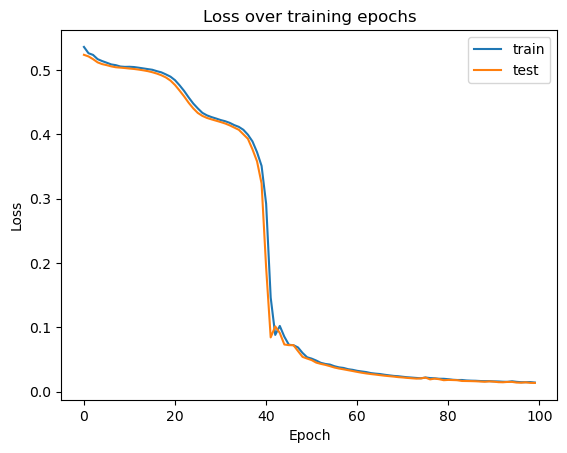

In [14]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

/var/folders/db/zt3c7s151gg33mj9zf3czwnr0000gn/T/ipykernel_16447/2822070687.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df_plot.iloc[:, 6:] = val_df_plot.iloc[:, 1:] * 0.1
/var/folders/db/zt3c7s151gg33mj9zf3czwnr0000gn/T/ipykernel_16447/2822070687.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


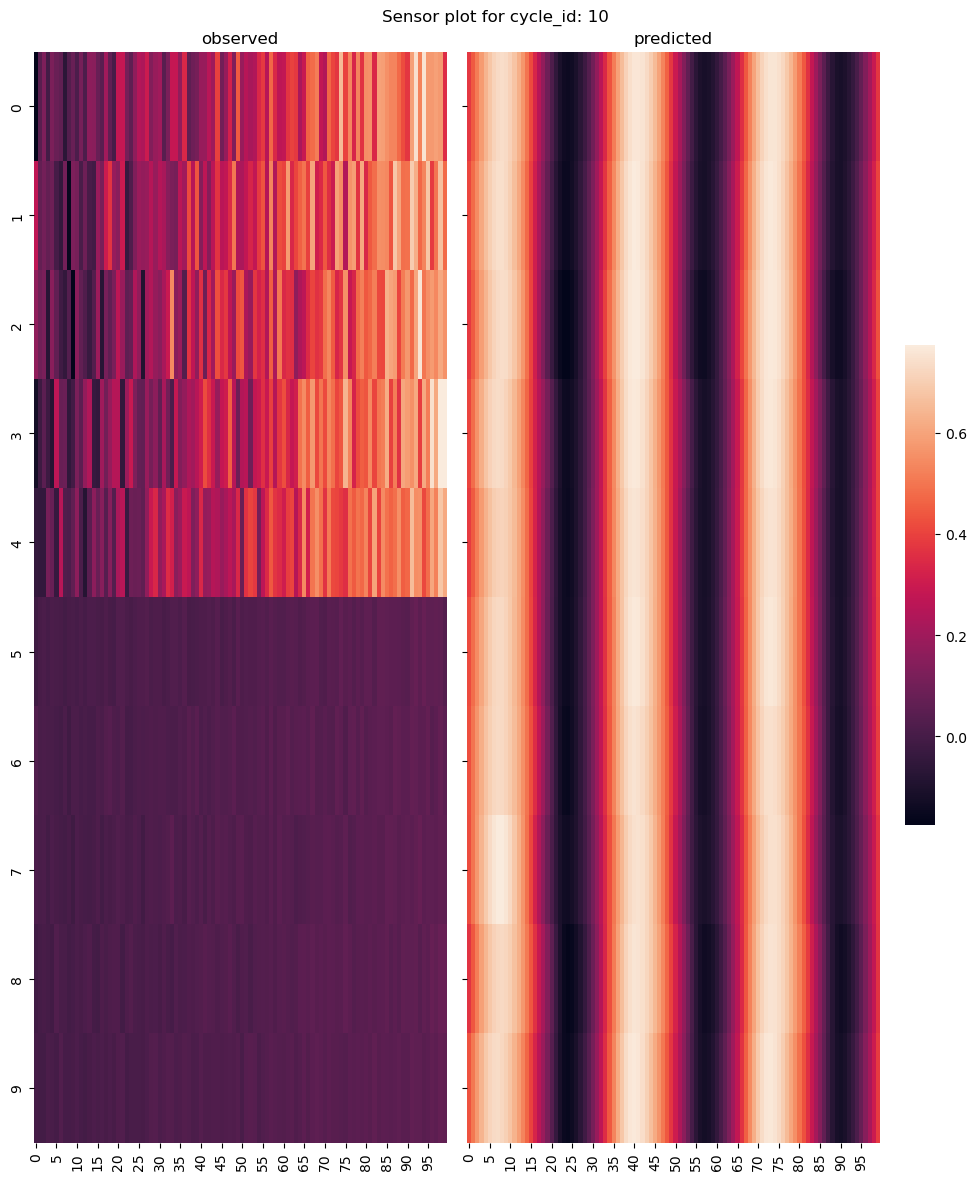

In [35]:
import seaborn as sns

test_cycle_id = '10'
# val_df_plot = df_val.loc[df_val.cycle_id==test_cycle_id]

val_df_plot = df[df['cycle_id']==test_cycle_id]
val_df_plot.iloc[:, 6:] = val_df_plot.iloc[:, 1:] * 0.1

val_tensor_plot = create_dataset(val_df_plot)

val_df_plot
datasets = {
    'observed': pd.DataFrame(val_tensor_plot.detach().numpy().reshape(-1, n_features).transpose()),
    'predicted': pd.DataFrame(model(val_tensor_plot).detach().numpy().reshape(-1, n_features).transpose())
}

fig, axes = plt.subplots(figsize=(10,12), nrows=1, ncols=2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

axes = axes.flatten()
for ax, x, title, i in zip(axes, datasets.values(), datasets.keys(), range(len(datasets))):
    ax.set_title(title)
    sns.heatmap(x, ax=ax, cbar=i==0, cbar_ax=None if i else cbar_ax)#, yticklabels=s)
plt.suptitle(f'Sensor plot for cycle_id: {test_cycle_id}')
fig.tight_layout(rect=[0, 0, .9, 1])

In [16]:
pd.DataFrame(val_tensor_plot.detach().numpy().reshape(-1, 10)).describe()

,0,1,2,3,4,5,6,7,8,9
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.289583,0.316637,0.295447,0.303077,0.293344,0.296541,0.283469,0.294953,0.319054,0.313067
std,0.194897,0.192321,0.195610,0.207145,0.188701,0.198939,0.203183,0.213527,0.194196,0.191885
min,-0.174977,-0.153332,-0.169275,-0.124928,-0.080609,-0.117036,-0.153819,-0.135377,-0.152067,-0.084513
25%,0.129020,0.180131,0.162894,0.154600,0.152822,0.172232,0.125416,0.140219,0.169183,0.154300
50%,0.275210,0.299489,0.308045,0.290449,0.313293,0.272509,0.277299,0.305173,0.320110,0.304381
75%,0.425597,0.474268,0.442993,0.452940,0.446879,0.457291,0.444692,0.442679,0.457788,0.445065
max,0.752891,0.692249,0.757438,0.773327,0.679266,0.758062,0.688475,0.770739,0.726285,0.778211


In [17]:
pd.DataFrame(model(val_tensor_plot).detach().numpy().reshape(-1, 10)).describe()

,0,1,2,3,4,5,6,7,8,9
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.003665,0.003464,-0.002940,0.009921,-0.003275,0.005316,0.005686,-0.001224,-0.005142,0.002165
std,0.704169,0.708216,0.733268,0.699036,0.692659,0.696944,0.694282,0.702485,0.709587,0.701751
min,-1.081781,-1.088571,-1.151092,-1.082901,-1.086676,-1.082027,-1.100271,-1.064967,-1.127150,-1.107352
25%,-0.678114,-0.682841,-0.719469,-0.640114,-0.666030,-0.662573,-0.647369,-0.672338,-0.680214,-0.651889
50%,0.045341,0.045966,0.040048,0.065605,0.060868,0.064501,0.074186,0.032670,0.059029,0.059434
75%,0.698570,0.678619,0.708167,0.677652,0.664757,0.661823,0.665331,0.698847,0.698484,0.673824
max,0.981189,1.000368,1.008154,0.998405,0.973475,0.995788,0.957932,1.001959,0.967558,0.999100


In [32]:
val_df_plot.iloc[:, 1:]

,0,1,2,3,4,5,6,7,8,9
0,-0.174977,0.270685,0.166807,-0.124928,-0.041821,-0.024533,0.216493,0.049399,-0.102690,-0.018773
1,0.040329,0.068874,0.098647,-0.019973,-0.048133,-0.055275,-0.093005,-0.059337,0.028236,0.250124
2,0.127425,0.102918,0.117921,0.050501,-0.048670,-0.060556,0.057247,-0.135377,0.125160,-0.081970
3,-0.007062,0.068564,-0.073852,-0.020364,0.110938,0.024118,0.084707,0.052220,0.132800,0.079573
4,0.122375,0.089354,0.154217,-0.084271,0.080484,0.124800,-0.093119,-0.070122,-0.035031,0.097805
...,...,...,...,...,...,...,...,...,...,...
95,0.576059,0.678587,0.552734,0.514037,0.483011,0.533011,0.688475,0.735048,0.598328,0.543586
96,0.574216,0.384558,0.580467,0.743917,0.604928,0.506015,0.575516,0.717330,0.625788,0.610754
97,0.588275,0.501190,0.538819,0.613029,0.521638,0.494230,0.602021,0.494833,0.721009,0.739334
98,0.575438,0.666018,0.609564,0.771753,0.679266,0.525573,0.573898,0.604847,0.538941,0.778211
